In [81]:
Name = "Luisa Danalachi"
Matriculation_Number = "7022909"

Name = "Victor Martinez Palomares"
Matriculation_Number = "7021729"

Name = "Soham Roy"
Matriculation_Number = "7028704"

In [14]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ./datasets
!mkdir ./datasets/lyme_dataset
!cp -r drive/MyDrive/Colab\ Notebooks/HLCV_project/datasets/lyme_dataset.zip ./datasets
!unzip -q -o "./datasets/lyme_dataset.zip" -d "./datasets/lyme_dataset"

'''
!mkdir ./resources


!cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources
!cp -r drive/MyDrive/Colab\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources

'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/lyme_dataset’: File exists


'\n!mkdir ./resources\n\n\n!cp -r drive/MyDrive/Colab\\ Notebooks/HLCV/Exercise_3/resources/fig1.png ./resources\n!cp -r drive/MyDrive/Colab\\ Notebooks/HLCV/Exercise_3/resources/fig2.png ./resources\n\n'

In [82]:
import os
import glob
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image





### Params

In [83]:
IMAGE_SIZE = 256
EPOCHS = 120
BATCH = 8
LR = 1e-4

path = "./datasets/lyme_dataset/RashData"

### Loading fine-tuning dataset

In [84]:
def load_data(path, train=True):
  if train:
    # load train data
    images = sorted(Path(os.path.join(path, "Train/Train_2_Cases/Lyme_Negative")).glob('**/*'))
    #images = sorted(glob(os.path.join(path, "Train/Train_2_Cases/Lyme_Negative/*")))
    masks = np.zeros(len(images))
    images1 = sorted(Path(os.path.join(path, "Train/Train_2_Cases/Lyme_Positive")).glob('**/*'))
    #images1 = (sorted(glob(os.path.join(path, "Train/Train_2_Cases/Lyme_Positive/*"))))
    images = images + images1
    masks = np.concatenate([masks,np.ones(len(images1))])
    total_size = len(images)
    dataset = list(zip(images, masks))
    random.shuffle(dataset)
    '''
    # split train/val data
    val_size = int(split * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    '''
    # unzip train data
    images, masks = zip(*dataset)
    #train_x = list(images)
    train_x = list(map(str, images))
    train_y = np.array(list(masks))

    return train_x, train_y
  else:
    # load test data
    images = sorted(Path(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Negative")).glob('**/*'))
    #images = sorted(glob(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Negative/*")))
    masks = np.zeros(len(images))
    images1 = sorted(Path(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Positive")).glob('**/*'))
    #images1 = (sorted(glob(os.path.join(path, "Validation/Validation_2_Cases/Lyme_Positive/*"))))
    images = images + images1
    masks = np.concatenate([masks,np.ones(len(images1))])

    c = list(zip(images, masks))
    random.shuffle(c)
    images, masks = zip(*c)

    #test_x = list(images)
    test_x = list(map(str, images))
    test_y = np.array(list(masks))

    #train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    #train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return test_x, test_y

In [85]:
train_x, train_y = load_data(path, train=True)
print("Training data: ", (train_x))
print(len(train_x))
test_x, test_y = load_data(path, train=False)
print("Testing data: ", (test_x))
print(len(test_x))

Training data:  ['datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm74.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans250.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans209.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans136.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash61.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash30.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans80.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/ringworm28.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Positive/erythema migrans129.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/Pityriasis rosea rash139.jpg', 'datasets/lyme_dataset/RashData/Train/Train_2_Cases/Lyme_Negative/rin

In [86]:

class LymeDataset(Dataset):
  def __init__(self, img_dir, train=True, transform=None):
    '''
    Args:
    root_dir (string): Directory with all the images.
    transform (callable, optional): Optional transform to be applied
      on a sample.
    '''
    self.train = train
    self.img_dir = img_dir
    self.transform = transform
    self.images_path, self.labels = load_data(img_dir, train)
  

  def __len__(self) -> int:
    return len(self.labels)

  def __getitem__(self, idx):
    img_path = self.images_path[idx]
    image = Image.open(img_path)
    #image = read_image(img_path)
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

In [ ]:
# Create dataloader


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


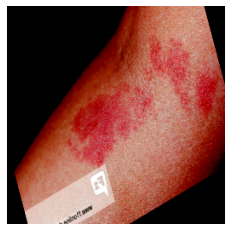

In [94]:
# Define augmentations and create dataloader

# Now
#import torch
#torch.manual_seed(17)
data_aug_transforms = []
data_aug_transforms.append(transforms.RandomRotation([-90, 90]) ) # geometric
data_aug_transforms.append( transforms.RandomHorizontalFlip() )  # geometric
#data_aug_transforms.append(transforms.ColorJitter(brightness = 0.2)) # brightness
norm_transforms = [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
train_transforms = transforms.Compose(data_aug_transforms + norm_transforms)
test_transforms = norm_transforms
train_val_dataset = LymeDataset(img_dir=path, train=True, transform=train_transforms)
test_dataset = LymeDataset(img_dir=path, train=False, transform=test_transforms)


# Draw the image being a tensor
image, label = train_val_dataset[0]
#plt.imshow(torch.reshape(image, (-1,)))
plt.imshow(image.permute(1, 2, 0))

plt.axis('off')

plt.show()


In [95]:
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
'''
  # split train/val data
  val_size = int(split * len(dataset))
  train_size = len(dataset) - val_size
  train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
  '''
val_split = 0.1
num_training = int((1 - val_split) * len(train_val_dataset))
num_validation = len(train_val_dataset) - num_training
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(train_val_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(train_val_dataset, mask)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


for i_batch, batch in enumerate(train_dataloader):
    # Draw the image being a tensor
    image= batch[0][0]
    label = batch[1][0]
    #ax0.imshow(torch.reshape(image, (-1,)))
    plt.imshow(image.permute(1, 2, 0))

    plt.axis('off')

    plt.show()

RuntimeError: ignored

### Extra code

In [ ]:
'''
def tf_parse(x,y):
  def _parse(x,y):
      x = read_image(x)
      return x,y

  x,y = tf.numpy_function(_parse, [x,y],  [tf.float64, tf.float64])
  #y = tf.cast(y, tf.double)
  x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
  #x = tf.cast(x, tf.double)
  return x,y

def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse)
  #print(dataset)
  dataset = dataset.map(data_augmentation)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)
'''

In [ ]:
images= np.zeros(20)
labels = np.ones(20)
data = list(zip(images,labels))
print(len(data))
print(data)
print(data.shape)